In [ ]:
pip install pydrive

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

df = pd.read_csv('data.csv')
df = df[['index', 'temperature']]
df['index'].min(), df['index'].max()

FileNotFoundError: ignored

In [ ]:
train, test = df.loc[df['index'] <= 3000], df.loc[df['index'] > 3000]
train.shape, test.shape

((3000, 2), (100, 2))

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['temperature']])

train['temperature'] = scaler.transform(train[['temperature']])
test['temperature'] = scaler.transform(test[['temperature']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
TIME_STEPS=1

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['temperature']], train['temperature'])
X_test, y_test = create_sequences(test[['temperature']], test['temperature'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (2999, 1, 1)
Testing shape: (99, 1, 1)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 1, 128)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_53 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 1, 1)              129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
85/85 [==============================] - 5s 15ms/step - loss: 0.7092 - val_loss: 0.9883
Epoch 2/100
85/85 [==============================] - 1s 6ms/step - loss: 0.7057 - val_loss: 0.9857
Epoch 3/100
85/85 [==============================] - 1s 6ms/step - loss: 0.7020 - val_loss: 0.9810
Epoch 4/100
85/85 [==============================] - 0s 6ms/step - loss: 0.7011 - val_loss: 0.9769
Epoch 5/100
85/85 [==============================] - 0s 5ms/step - loss: 0.6978 - val_loss: 0.9711
Epoch 6/100
85/85 [==============================] - 0s 6ms/step - loss: 0.6955 - val_loss: 0.9692
Epoch 7/100
85/85 [==============================] - 1s 6ms/step - loss: 0.6934 - val_loss: 0.9682
Epoch 8/100
85/85 [==============================] - 0s 6ms/step - loss: 0.6910 - val_loss: 0.9648
Epoch 9/100
85/85 [==============================] - 1s 6ms/step - loss: 0.6920 - val_loss: 0.9637
Epoch 10/100
85/85 [==============================] - 0s 6ms/step - loss: 0.6940 - val_loss: 0.9631
Epoch 11

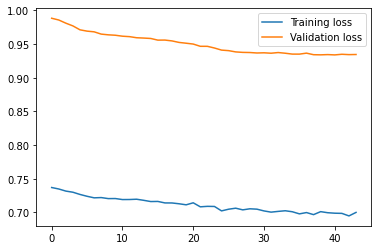

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.7921


0.7920761108398438

Reconstruction error threshold: 4.321184807059292


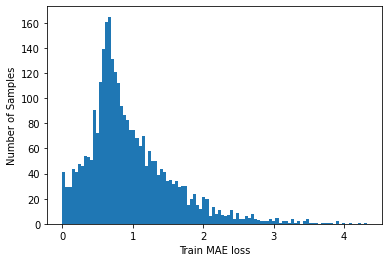

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=100)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

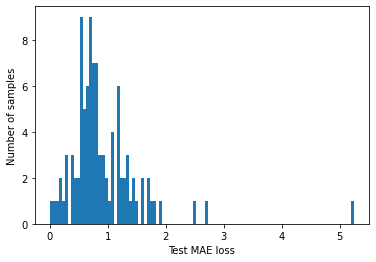

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=100)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['temperature'] = test[TIME_STEPS:]['temperature']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['index'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['index'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(1, 5)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['index'], y=scaler.inverse_transform(test_score_df['temperature']), name='temperature'))
fig.add_trace(go.Scatter(x=anomalies['index']-1, y=scaler.inverse_transform(anomalies['temperature']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [ ]:
print

<function print>